Water_Consumption    0
dtype: int64
                     Water_Consumption
Timestamp                             
2024-12-28 00:16:37             4684.8
2024-12-28 05:32:02             4684.9
2024-12-28 11:32:01             4686.3
2024-12-28 17:32:02             4687.1
2024-12-28 23:32:01             4687.3
2024-12-29 00:16:37             4687.3
2024-12-29 05:32:02             4687.5
2024-12-29 11:32:02             4687.7
2024-12-29 17:32:02             4687.9
2024-12-29 23:32:02             4688.0
2024-12-30 00:16:38             4688.0
2024-12-30 05:32:03             4688.2
2024-12-30 11:32:02             4688.5
2024-12-30 17:32:02             4689.0
2024-12-30 23:32:03             4689.1
2024-12-31 00:16:38             4689.1
2024-12-31 05:32:03             4689.2
2024-12-31 11:32:03             4692.5
2024-12-31 17:32:03             4695.1
2024-12-31 23:32:03             4696.7


C:\Users\tamil\AppData\Local\Temp\ipykernel_10736\449069959.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d-%m-%Y %H:%M:%S")
C:\Users\tamil\AppData\Local\Temp\ipykernel_10736\449069959.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(columns=["Date", "Time","Device Name"], inplace=True)
C:\Users\tamil\AppData\Local\Temp\ipykernel_10736\449069959.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the 

<Axes: xlabel='Timestamp'>

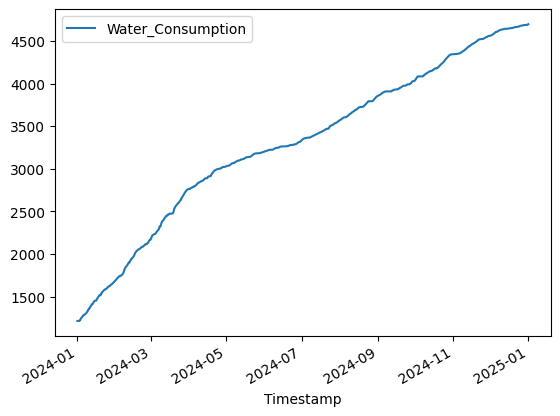

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Load dataset
water_usage = pd.read_csv('Water Usage/SOC Outlet-1/Table.csv',
                          usecols=["Date", "Time", "Device Name", "water_flow_in_cubic_meter"])

# Reverse order if needed
data = water_usage[::-1]


#data = data.drop_duplicates(subset=["Date"], keep="first")  # Keep first occurrence

# Set index and ensure DateTime format
data["Timestamp"] = pd.to_datetime(data["Date"] + " " + data["Time"],format="%d-%m-%Y %H:%M:%S")
#data["Rounded_Timestamp"] = data["Timestamp"].dt.round("6H")

# Set the new Timestamp as index
data.set_index("Timestamp", inplace=True)

# Drop the original "Date" and "Time" columns if no longer needed
data.drop(columns=["Date", "Time","Device Name"], inplace=True)


# Ensure daily frequency
#data["Water_Consumption"] = data["water_flow_in_litre"].diff()
#data = data.dropna()
# Rename column
data.rename(columns={'water_flow_in_cubic_meter': 'Water_Consumption'}, inplace=True)
#print(data.isna().sum())
#data.interpolate(method="linear", inplace=True)
# Display first 20 rows
print(data.tail(20))
data.plot()

In [2]:
# Normalize data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Converts data into sequences for LSTM
def create_sequences(data, time_steps=10):
    """ Create input-output pairs for LSTM training. """
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])  # Use past 'time_steps' values as input
        y.append(data[i + time_steps])      # Predict the next value
    X, y = np.array(X), np.array(y)

    # Ensure 3D shape: (samples, time_steps, features=1)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    return X, y

# Define time steps (e.g., past 7 readings)
time_steps = 7
data_values=data["Water_Consumption"].values
X, y = create_sequences(data, time_steps)

In [3]:
# Split into train/test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [4]:
# Build GRU Model
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(time_steps, 1)),
    GRU(32),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')


C:\Users\tamil\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 9319432.0000 - val_loss: 20244102.0000
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 9356878.0000 - val_loss: 20215802.0000
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9276097.0000 - val_loss: 20188818.0000
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9268975.0000 - val_loss: 20162324.0000
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9306602.0000 - val_loss: 20136014.0000
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9388538.0000 - val_loss: 20109948.0000
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9331716.0000 - val_loss: 20084000.0000
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9311936.0000 - val_loss: 20058254.0000
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9349490.0000 - val_loss: 20032406.0000
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9388288.0000 - val_loss: 20006644.0000
Epoch 11/50
87/87 ━

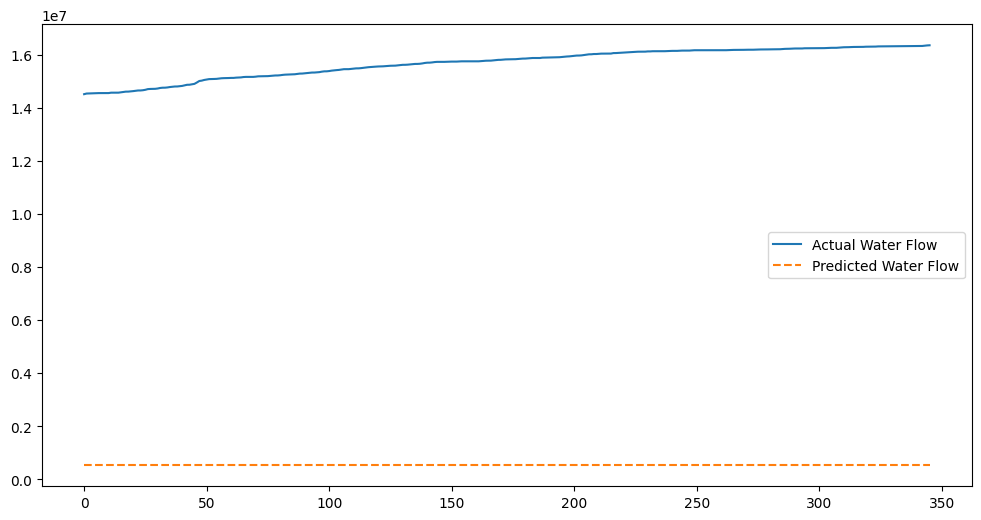

In [5]:
# Train Model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16)

# Predictions
y_pred = model.predict(X_test)

# Inverse transform results
y_test_inv = scaler.inverse_transform(np.column_stack((np.zeros_like(y_test), y_test)))[:, 1]
y_pred_inv = scaler.inverse_transform(np.column_stack((np.zeros_like(y_pred), y_pred)))[:, 1]

# Evaluate Model
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f'RMSE: {rmse:.2f}')

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Water Flow')
plt.plot(y_pred_inv, label='Predicted Water Flow', linestyle='dashed')
plt.legend()
plt.show()